# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from paraspec.base import IR12SpeciationModel

In [2]:
def run_model():
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    elevation = X + r.rand(*Y.shape)
    pop_size = 10
    num_gen = 100
    model = IR12SpeciationModel(X, Y, pop_size,
                                nb_radius=50, car_cap=50,
                                sigma_w=0.2, sigma_mov=5, sigma_mut=0.05,
                                lifespan=1, mut_prob=0.05, random_seed=1234)
    model.initialize([[0.5, 0.5]])
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(elevation, elevation.min(), elevation.max(), 1)
        dfs.append(model.to_dataframe())
        model.update_population(1)
    return pd.concat(dfs).reset_index(drop=True), elevation, num_gen, X

In [3]:
population1, elevation, num_gen, X = run_model()

In [4]:
def plot_sol(population1, elevation, num_gen, X):
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(population1.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=population1['step'], y=population1['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(population1['x'].loc[population1['step']==max(population1['step'])],
                       population1['y'].loc[population1['step']==max(population1['step'])],
                       c=population1['trait_0'].loc[population1['step']==max(population1['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=population1['x'].loc[population1['step']==max(population1['step'])],
                                     y=population1['trait_0'].loc[population1['step']==max(population1['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

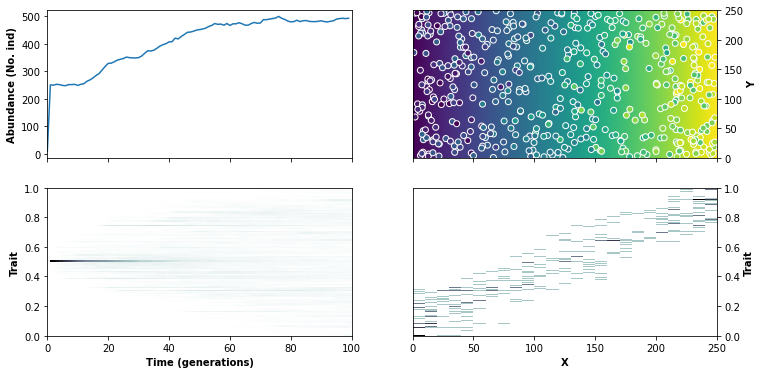

In [5]:
plot_sol(population1, elevation, num_gen, X)

In [6]:
def taxon_lineage(population):
    col_traits = population.columns[population.columns.str.contains('trait_')].to_list()
    initial_data = population.groupby('time').get_group(0)
    dtf_cols = initial_data.columns.to_list()
    dtf_cols.append("taxon_id")
    dtf_cols.append("ancestor_id")
    out_dtf=pd.DataFrame(columns=dtf_cols)
    col_traits.append('ancestor_id')
    _hclust = linkage(initial_data[["trait_0"]].to_numpy(), method='ward')
    _clus = fcluster(_hclust, 0.5, 'distance')
    out_dtf = out_dtf.append(initial_data.assign(taxon_id=_clus, ancestor_id=_clus))
    
    for i in population['time'].unique()[1:].astype(int):
        ancestor_data = out_dtf.groupby('time').get_group(i-1)
        current_ancestor_id = np.repeat(ancestor_data['taxon_id'], ancestor_data['n_offspring'])
        current_data = population1.groupby('time').get_group(i)
        current_data = current_data.assign(ancestor_id=current_ancestor_id.values)
        _hclust = linkage(current_data[["trait_0", "ancestor_id"]].to_numpy(), method='ward')
        _clus = fcluster(_hclust, 0.5, 'distance')
        current_data = current_data.assign(taxon_id=_clus + current_ancestor_id.max())
        out_dtf = out_dtf.append(current_data)
    
    return out_dtf

In [7]:
dtf_out = taxon_lineage(population1)
dtf_out

,step,time,dt,id,parent,x,y,r_d,opt_trait,fitness,n_offspring,trait_0,taxon_id,ancestor_id
0,0,0.0,0.0,0,0,110.251531,15.034664,50.000000,0.444406,0.962103,48,0.500000,1,1
1,0,0.0,0.0,1,1,152.467702,170.922227,50.000000,0.600738,0.880864,44,0.500000,1,1
2,0,0.0,0.0,2,2,215.905324,167.809505,25.000000,0.845671,0.224561,6,0.500000,1,1
3,0,0.0,0.0,3,3,215.939418,152.754495,25.000000,0.844245,0.227340,6,0.500000,1,1
4,0,0.0,0.0,4,4,168.720328,15.034328,50.000000,0.667795,0.703322,35,0.500000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40490,99,99.0,0.0,40490,39997,50.067842,4.060274,1.136364,0.217350,0.906405,1,0.306015,1347,1332
40491,99,99.0,0.0,40491,39998,41.982479,37.866272,0.892857,0.184139,0.976277,1,0.227964,1347,1332
40492,99,99.0,0.0,40492,39999,56.706385,16.585954,0.925926,0.243719,0.944841,1,0.311092,1347,1332
40493,99,99.0,0.0,40493,40000,37.499168,27.003395,0.961538,0.168529,0.784309,1,0.307943,1347,1332


In [8]:
def tree_taxon(dtf):
    col_traits = dtf.columns[dtf.columns.str.contains('trait_')].to_list()
    traits_taxon = (dtf
               .groupby(['time', 'taxon_id', 'ancestor_id'])[col_traits]
               .mean()
               .reset_index()
               )
    abundace_taxon=(dtf.groupby(['time', 'taxon_id', 'ancestor_id'])
          .size().rename('abundance')
          .reset_index()
         )
     
    dtf_out = pd.merge(traits_taxon, abundace_taxon).rename(columns={'taxon_id': 'id', 'ancestor_id': 'parent'})
        
    dtf_out = (dtf_out.assign(node_type=dtf_out.ptree.node_type,
                tree_id=dtf_out.ptree.tree_id,
                #length=np.repeat(1, dtf_out['time'].size))
            
            ))
    return dtf_out

In [9]:
tree_spp = tree_taxon(dtf_out)
tree_spp

,time,id,parent,trait_0,abundance,node_type,tree_id
0,0.0,1,1,0.500000,10,root,1
1,1.0,2,1,0.499174,251,node,1
2,2.0,3,2,0.499883,250,node,1
3,3.0,4,3,0.500391,253,node,1
4,4.0,5,4,0.500080,252,node,1
...,...,...,...,...,...,...,...
1353,99.0,1354,1328,0.564059,5,leaf,1
1354,99.0,1355,1321,0.172931,14,leaf,1
1355,99.0,1356,1322,0.539072,23,leaf,1
1356,99.0,1357,1324,0.095446,47,leaf,1


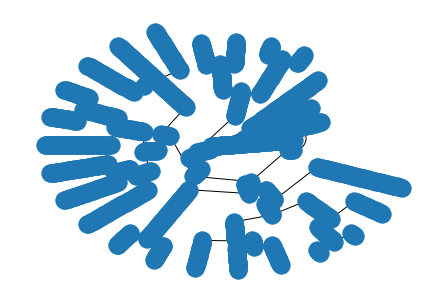

In [10]:
G = (tree_spp
     .ptree.to_networkx(node_col='trait_0'))


nx.draw(G, pos=graphviz_layout(G, prog='twopi', root=None))